In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
#import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_pickle("./de_sp_orders_from_tiers_51-56.pkl")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17889747 entries, 0 to 18158738
Data columns (total 26 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              float64
OSP_3_LEAD_P_PG_SHARE           float64
OSP_4_LEAD_P_PG_ID              float64
OSP_4_LEAD_P_PG_SHARE           float64
CZP_START_DATE                  datetime64[ns]
CZP_EXPIRY_DATE                 datetime64[ns]
CZP_ZTQ_ID                      int64
CZP_PERCENTAGE                  int64
CZP_P

In [4]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,ORDER_DATETIME,WEEK_NUMBER,MONTH_NUMBER
0,407217670,95439127,2017-10-01,12:11,1,10979411,19.99,7.8983,7.0450,16.7983,...,2157.0,1.0,2016-08-30 19:53:00,2019-09-01 23:59:00,54,7,16.99,2017-10-01 12:11:00,39,10
1,407217673,95439127,2017-10-01,12:11,1,10979411,-12.11,-10.1765,-10.1765,-10.1765,...,2157.0,1.0,2016-08-30 19:53:00,2019-09-01 23:59:00,54,7,16.99,2017-10-01 12:11:00,39,10
2,407217669,95439127,2017-10-01,12:11,1,10979411,125.98,20.0255,17.1232,105.8655,...,2157.0,1.0,2016-08-30 19:53:00,2019-09-01 23:59:00,54,7,16.99,2017-10-01 12:11:00,39,10
3,407217671,95439127,2017-10-01,12:11,1,10979411,0.00,-2.7800,-4.0404,0.0000,...,2157.0,1.0,2016-08-30 19:53:00,2019-09-01 23:59:00,54,7,16.99,2017-10-01 12:11:00,39,10
4,407217672,95439127,2017-10-01,12:11,1,10979411,26.97,9.5539,8.1569,22.6639,...,2157.0,1.0,2016-08-30 19:53:00,2019-09-01 23:59:00,54,7,16.99,2017-10-01 12:11:00,39,10


In [5]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [6]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [7]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [8]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [9]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'WEEK_NUMBER', 'MONTH_NUMBER',
       'FIRST_O_DATE', 'LAST_O_DATE', '1ST_O_COUNTER', 'D28', 'D56', 'D84',
       'D168', 'D252', 'D336'],
      dtype='object')

In [10]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'CZP_ZTQ_ID': min, 
          'SCM_SALES_BMF': sum,
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [11]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [12]:
#orders.to_pickle("./test_order_level_de_sp_orders_from_tiers_51-56.pkl")

In [13]:
data['SCM_N_ORDER_NR'].nunique(), len(orders)

(2606951, 2606951)

In [14]:
orders.tail()

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,OSP_KO_COUNT_NET,CZP_START_DATE,...,ORDER_DATETIME,FIRST_O_DATE,LAST_O_DATE,1ST_O_COUNTER,D28,D56,D84,D168,D252,D336
2606946,120154322,2018-09-30,6361585,52,68.3399,19.0115,10.5694,63.6014,107,2017-03-23 22:29:00,...,2018-09-30 23:58:00,2017-10-09,2018-09-30,87,2017-11-06,2017-12-04,2018-01-01,2018-03-26,2018-06-18,2018-09-10
2606947,120154334,2018-09-30,9382588,53,35.1000,8.0186,3.5491,32.6286,31,2018-03-06 22:54:00,...,2018-09-30 23:59:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,2018-09-17
2606948,120154335,2018-09-30,7622181,51,69.7500,18.8694,9.7575,64.2494,70,2018-08-28 00:00:00,...,2018-09-30 23:59:00,2017-11-09,2018-09-30,60,2017-12-07,2018-01-04,2018-02-01,2018-04-26,2018-07-19,2018-10-11
2606949,120154336,2018-09-30,5748277,54,243.5401,65.9116,34.0434,220.9715,85,2015-11-16 23:21:00,...,2018-09-30 23:59:00,2017-12-01,2018-09-30,83,2017-12-29,2018-01-26,2018-02-23,2018-05-18,2018-08-10,2018-11-02
2606950,120154339,2018-09-30,525064,54,87.3800,7.2685,-4.0307,73.4285,142,2017-09-24 20:30:00,...,2018-09-30 23:59:00,2017-11-30,2018-09-30,132,2017-12-28,2018-01-25,2018-02-22,2018-05-17,2018-08-09,2018-11-01


In [15]:
orders.groupby('CUS_N_KEY_CUSTOMER')['OSP_KO_COUNT_NET'].min().loc[9382588]

21

In [16]:
orders['OK_28D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D28']) * 1
orders['OK_56D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D56']) * 1
orders['OK_84D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D84']) * 1
orders['OK_168D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D168']) * 1
orders['OK_252D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D252']) * 1
orders['OK_336D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D336']) * 1

In [17]:
orders['COUNTER_28D'] = orders['OK_28D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_56D'] = orders['OK_56D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_84D'] = orders['OK_84D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_168D'] = orders['OK_168D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_252D'] = orders['OK_252D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_336D'] = orders['OK_336D'] * orders['OSP_KO_COUNT_NET']

In [18]:
orders['MAX_COUNTER_28D'] = orders['COUNTER_28D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_56D'] = orders['COUNTER_56D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_84D'] = orders['COUNTER_84D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_168D'] = orders['COUNTER_168D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_252D'] = orders['COUNTER_252D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_336D'] = orders['COUNTER_336D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')

In [19]:
orders['RR_28D'] = (orders['MAX_COUNTER_28D'] > orders['1ST_O_COUNTER']) * 1
orders['RR_56D'] = (orders['MAX_COUNTER_56D'] > orders['MAX_COUNTER_28D']) * 1
orders['RR_84D'] = (orders['MAX_COUNTER_84D'] > orders['MAX_COUNTER_56D']) * 1 
orders['RR_168D'] = (orders['MAX_COUNTER_168D'] > orders['MAX_COUNTER_84D']) * 1
orders['RR_252D'] = (orders['MAX_COUNTER_252D'] > orders['MAX_COUNTER_168D']) * 1 
orders['RR_336D'] = (orders['MAX_COUNTER_336D'] > orders['MAX_COUNTER_168D']) * 1

In [20]:
orders[orders['CUS_N_KEY_CUSTOMER'] == 9382588][orders.columns[10:]]

,CZP_EXPIRY_DATE,ORDER_DATETIME,FIRST_O_DATE,LAST_O_DATE,1ST_O_COUNTER,D28,D56,D84,D168,D252,...,MAX_COUNTER_84D,MAX_COUNTER_168D,MAX_COUNTER_252D,MAX_COUNTER_336D,RR_28D,RR_56D,RR_84D,RR_168D,RR_252D,RR_336D
103715,2018-01-24 23:59:00,2017-10-16 22:09:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
456820,2018-01-24 23:59:00,2017-12-04 01:01:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
573885,2018-01-24 23:59:00,2017-12-16 13:06:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
574271,2018-01-24 23:59:00,2017-12-16 14:05:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
822073,2018-01-24 23:59:00,2018-01-23 06:46:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
1141054,2019-03-06 23:59:00,2018-03-06 22:54:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
1440229,2019-03-06 23:59:00,2018-04-16 23:23:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
1801452,2019-03-06 23:59:00,2018-06-08 06:33:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
2055921,2019-03-06 23:59:00,2018-07-13 03:38:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1
2313725,2019-03-06 23:59:00,2018-08-21 07:08:00,2017-10-16,2018-09-30,21,2017-11-13,2017-12-11,2018-01-08,2018-04-02,2018-06-25,...,24,26,28,30,0,1,1,1,1,1


In [21]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'CZP_ZTQ_ID', 'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'OK_28D',
       'OK_56D', 'OK_84D', 'OK_168D', 'OK_252D', 'OK_336D', 'COUNTER_28D',
       'COUNTER_56D', 'COUNTER_84D', 'COUNTER_168D', 'COUNTER_252D',
       'COUNTER_336D', 'MAX_COUNTER_28D', 'MAX_COUNTER_56D', 'MAX_COUNTER_84D',
       'MAX_COUNTER_168D', 'MAX_COUNTER_252D', 'MAX_COUNTER_336D', 'RR_28D',
       'RR_56D', 'RR_84D', 'RR_168D', 'RR_252D', 'RR_336D'],
      dtype='object')

In [22]:
agg_ord_ops = {'CZP_ZTQ_ID': 'unique',
              'SCM_N_ORDER_NR': len,
              'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'CZP_START_DATE': 'unique',
              'CZP_EXPIRY_DATE': 'unique',
              'FIRST_O_DATE': min,
              'LAST_O_DATE': min,
              '1ST_O_COUNTER': min,
              'COUNTER_28D': max,
              'COUNTER_56D': max,
              'COUNTER_84D': max,
              'COUNTER_168D': max,
              'COUNTER_252D': max,
              'COUNTER_336D': max
              }

In [23]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [24]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [25]:
customers.head()

,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID_unique,SCM_N_ORDER_NR_len,SCM_SALES_BMF_sum,SCM_SALES_BMF_<lambda>,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_<lambda>,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_<lambda>,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,CZP_EXPIRY_DATE_unique,FIRST_O_DATE_min,LAST_O_DATE_min,1ST_O_COUNTER_min,COUNTER_28D_max,COUNTER_56D_max,COUNTER_84D_max,COUNTER_168D_max,COUNTER_252D_max,COUNTER_336D_max
0,54,[52],2,57.25,"[28.8, 28.45]",25.61,"[12.61, 13.0]",11.19,"[6.81, 4.37]",48.51,...,[2018-12-06T23:59:00.000000000],2018-05-16,2018-07-15,51,51,51,52,52,52,52
1,84,[54],1,228.78,[228.78],32.55,[32.55],2.30,[2.3],202.46,...,[2017-10-30T23:59:00.000000000],2017-10-12,2017-10-12,149,149,149,149,149,149,149
2,151,[53],1,108.62,[108.62],41.18,[41.18],36.17,[36.17],100.82,...,[2019-02-09T23:59:00.000000000],2018-02-09,2018-02-09,69,69,69,69,69,69,69
3,176,[51],8,304.14,"[31.03, 57.98, 32.8, 19.54, 22.36, 48.76, 70.5...",45.94,"[5.24, 9.38, 3.05, 3.78, -0.29, 10.13, 10.2, 4...",-1.03,"[1.4, 0.34, -1.87, -0.46, -5.37, 3.27, 1.62, 0...",269.16,...,"[2018-02-24T15:30:00.000000000, 2019-03-21T23:...",2017-11-03,2018-06-01,50,50,51,53,56,57,57
4,205,[51],9,1178.91,"[39.48, 130.32, 130.32, 155.2, 293.85, 104.21,...",348.56,"[9.44, 39.41, 39.41, 42.15, 88.32, 23.69, 55.6...",255.20,"[4.67, 30.4, 27.51, 33.27, 67.26, 14.58, 45.6,...",1075.35,...,"[2018-03-10T23:59:00.000000000, 2019-03-14T00:...",2017-10-03,2018-04-30,107,108,109,111,112,115,115


In [26]:
customers['DIFF_DAYS'] = (customers['LAST_O_DATE_min'] - customers['FIRST_O_DATE_min']).dt.days

In [27]:
customers['SUIT_28D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=28)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_56D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=56)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_84D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=84)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_168D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=168)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_252D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=252)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_336D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=336)) >= customers['FIRST_O_DATE_min']) * 1

In [28]:
customers['R28D'] = (customers['COUNTER_28D_max'] > customers['1ST_O_COUNTER_min']) * 1
customers['R56D'] = (customers['COUNTER_56D_max'] > customers['COUNTER_28D_max']) * 1
customers['R84D'] = (customers['COUNTER_84D_max'] > customers['COUNTER_56D_max']) * 1
customers['R168D'] = (customers['COUNTER_168D_max'] > customers['COUNTER_84D_max']) * 1
customers['R252D'] = (customers['COUNTER_252D_max'] > customers['COUNTER_168D_max']) * 1
customers['R336D'] = (customers['COUNTER_336D_max'] > customers['COUNTER_252D_max']) * 1

In [29]:
customers['RR_28D'] = customers['R28D']
customers['RR_56D'] = customers['R56D'] | customers['RR_28D']
customers['RR_84D'] = customers['R84D'] | customers['RR_56D']
customers['RR_168D'] = customers['R168D'] | customers['RR_84D']
customers['RR_252D'] = customers['R252D'] | customers['RR_168D']
customers['RR_336D'] = customers['R336D'] | customers['RR_252D']

In [30]:
customers['R_28D'] = customers['RR_28D'] * customers['SUIT_28D']
customers['R_56D'] = customers['RR_56D'] * customers['SUIT_56D']
customers['R_84D'] = customers['RR_84D'] * customers['SUIT_84D']
customers['R_168D'] = customers['RR_168D']  * customers['SUIT_168D']
customers['R_252D'] = customers['RR_252D'] * customers['SUIT_252D']
customers['R_336D'] = customers['RR_336D'] * customers['SUIT_336D']

In [31]:
customers.to_pickle("./test_local_de_sp_customers_tiers_51-56.pkl")

In [32]:
mask = [len(i) == 1 for i in customers['CZP_ZTQ_ID_unique'].values]

In [33]:
sp_customers = customers[mask]

In [34]:
def get_number_from_string(i):
    changes = str(i).replace('[', '').replace(']', '')
    return int(changes)

In [35]:
t_customers = sp_customers.copy()

In [36]:
t_customers['CZP_ZTQ_ID_unique'] = t_customers['CZP_ZTQ_ID_unique'].map(get_number_from_string)

In [37]:
t_customers['CZP_ZTQ_ID_unique'].value_counts()

51    115231
52     69540
53     51163
54     42159
56     37776
55     14656
Name: CZP_ZTQ_ID_unique, dtype: int64

In [38]:
t_customers.sample(10)[t_customers.columns[-25:]]

,DIFF_DAYS,SUIT_28D,SUIT_56D,SUIT_84D,SUIT_168D,SUIT_252D,SUIT_336D,R28D,R56D,R84D,...,RR_84D,RR_168D,RR_252D,RR_336D,R_28D,R_56D,R_84D,R_168D,R_252D,R_336D
23155,318,1,1,1,1,1,1,0,0,1,...,1,1,1,1,0,0,1,1,1,1
116202,303,1,1,1,1,1,1,0,0,1,...,1,1,1,1,0,0,1,1,1,1
292505,331,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
41736,189,1,1,1,1,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,0
267100,288,1,1,1,1,1,0,0,0,1,...,1,1,1,1,0,0,1,1,1,0
181831,294,1,1,1,1,1,0,0,0,1,...,1,1,1,1,0,0,1,1,1,0
316972,320,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,0
130014,354,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
339272,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33799,258,1,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,0


In [39]:
tier_rr_28d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_28D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_28D'].sum() * 100).round(2)
tier_rr_56d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_56D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_56D'].sum() * 100).round(2)
tier_rr_84d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_84D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_84D'].sum() * 100).round(2)
tier_rr_168d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_168D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_168D'].sum() * 100).round(2)
tier_rr_252d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_252D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_252D'].sum() * 100).round(2)
tier_rr_336d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_336D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_336D'].sum() * 100).round(2)

In [40]:
rep_rate_tiers = pd.DataFrame([tier_rr_28d, tier_rr_56d, tier_rr_84d, tier_rr_168d, tier_rr_252d, tier_rr_336d]).T
rep_rate_tiers.columns = ['28d', '56d', '84d', '168d', '252d', '336d']
rep_rate_tiers

,28d,56d,84d,168d,252d,336d
CZP_ZTQ_ID_unique,,,,,,
51,32.10,61.92,75.86,88.39,92.27,95.68
52,33.29,61.59,75.68,90.46,95.08,97.85
53,32.74,62.13,76.10,88.80,92.53,95.76
54,35.79,63.18,77.13,91.22,95.16,97.81
55,26.47,48.53,59.88,72.74,77.20,81.07
56,30.75,53.67,65.24,77.13,80.12,84.38


In [41]:
ztq = [51, 52, 53, 54, 55, 56]

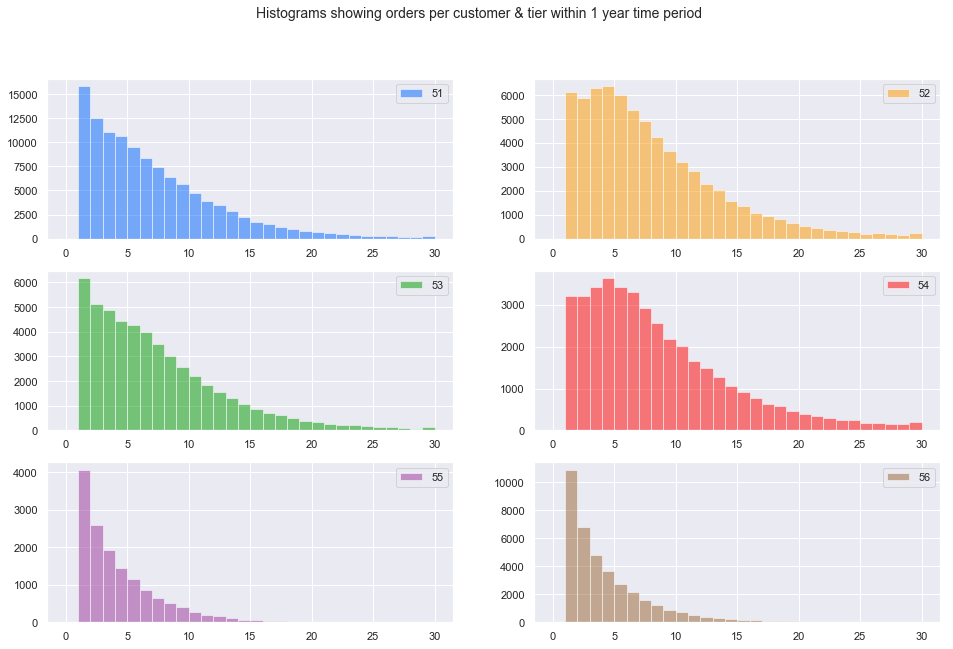

,Tier 51 ORDERS,Tier 52 ORDERS,Tier 53 ORDERS,Tier 54 ORDERS,Tier 55 ORDERS,Tier 56 ORDERS
count,115231.00,69540.00,51163.00,42159.00,14656.00,37776.00
mean,6.83,7.97,7.19,9.11,3.91,5.05
std,6.09,7.11,6.30,40.08,3.46,79.94
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.00,3.00,3.00,4.00,1.00,1.00
50%,5.00,6.00,6.00,7.00,3.00,3.00
75%,9.00,11.00,10.00,12.00,5.00,5.00
max,235.00,268.00,172.00,7962.00,42.00,8585.00


In [42]:
sns.set()
plt.figure(figsize=(16,10))
plt.suptitle('Histograms showing orders per customer & tier within 1 year time period', fontsize=14)
plt.subplot(321)
data_tier_51 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 51]
data_tier_51['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#0066ff', alpha=0.5)
plt.legend([51])
plt.subplot(322)
data_tier_52 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 52]
data_tier_52['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff9900', alpha=0.5)
plt.legend([52])
plt.subplot(323)
data_tier_53 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 53]
data_tier_53['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#009900', alpha=0.5)
plt.legend([53])
plt.subplot(324)
data_tier_54 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 54]
data_tier_54['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff0000', alpha=0.5)
plt.legend([54])
plt.subplot(325)
data_tier_55 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 55]
data_tier_55['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#993399', alpha=0.5)
plt.legend([55])
plt.subplot(326)
data_tier_56 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 56]
data_tier_56['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#996633', alpha=0.5)
plt.legend([56])
plt.show() 

concat_df = pd.DataFrame()
for tq in ztq:
    data_tier = t_customers[t_customers['CZP_ZTQ_ID_unique'] == tq]
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_tier['SCM_N_ORDER_NR_len'].describe().round(2)),
                           ], axis=1)
concat_df.columns = ['Tier 51 ORDERS', 'Tier 52 ORDERS', 'Tier 53 ORDERS',
                     'Tier 54 ORDERS', 'Tier 55 ORDERS', 'Tier 56 ORDERS']
display(concat_df)

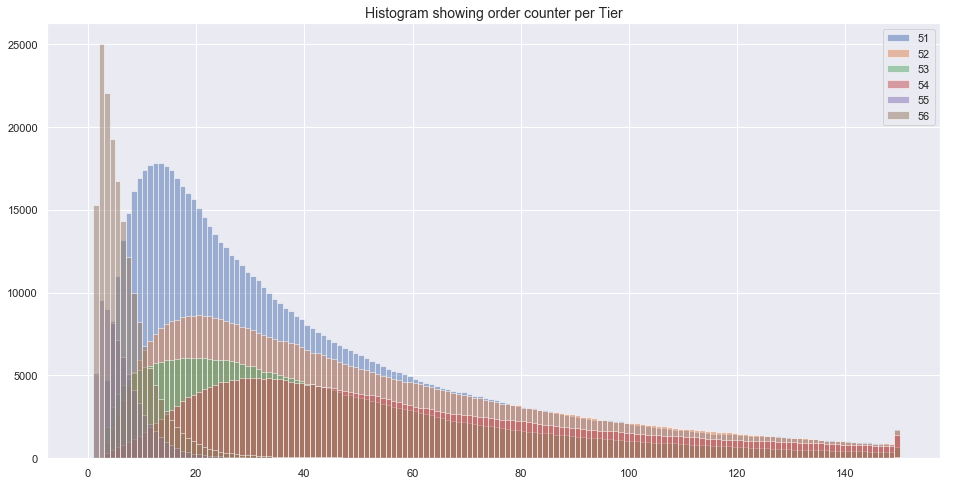

,Tier 51 Order_Counter,Tier 52 Order_Counter,Tier 53 Order_Counter,Tier 54 Order_Counter,Tier 55 Order_Counter,Tier 56 Order_Counter
count,862226.00,629740.00,398433.00,419209.00,70533.00,226810.00
mean,53.83,71.52,57.59,216.14,6.61,598.76
std,60.90,94.84,61.17,936.89,9.51,1527.20
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,17.00,26.00,22.00,35.00,3.00,3.00
50%,34.00,49.00,40.00,61.00,5.00,7.00
75%,68.00,89.00,71.00,115.00,8.00,16.00
max,932.00,4699.00,869.00,10441.00,260.00,8589.00


In [43]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order counter per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_counter_values = [i for i in data_tier['OSP_KO_COUNT_NET'].values]
    plt.hist(order_counter_values, bins=150, range=(0, 150), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_counter_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Counter', 'Tier 52 Order_Counter', 'Tier 53 Order_Counter',
                     'Tier 54 Order_Counter', 'Tier 55 Order_Counter', 'Tier 56 Order_Counter']
display(concat_df)

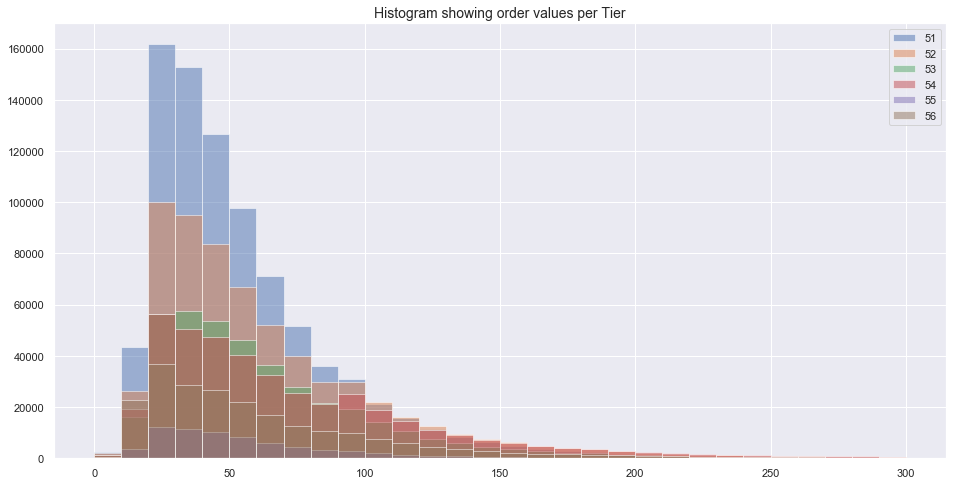

,Tier 51 Order_Values,Tier 52 Order_Values,Tier 53 Order_Values,Tier 54 Order_Values,Tier 55 Order_Values,Tier 56 Order_Values
count,862226.00,629740.00,398433.00,419209.00,70533.00,226810.00
mean,55.65,65.34,65.13,76.91,57.26,67.45
std,39.70,55.51,52.05,70.97,39.79,108.25
min,-91.34,-61.04,-59.48,-78.67,-19.43,-75.65
25%,30.37,32.88,34.39,35.48,31.03,28.47
50%,45.43,50.88,52.94,58.44,47.40,48.94
75%,68.19,81.67,81.59,97.51,71.23,82.84
max,2807.06,7491.78,4469.13,3904.61,1021.01,8709.36


In [44]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order values per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values = [i for i in data_tier['SCM_SALES_BMF'].values]
    plt.hist(order_values, bins=30, range=(0, 300), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Values', 'Tier 52 Order_Values', 'Tier 53 Order_Values',
                     'Tier 54 Order_Values', 'Tier 55 Order_Values', 'Tier 56 Order_Values']
display(concat_df)

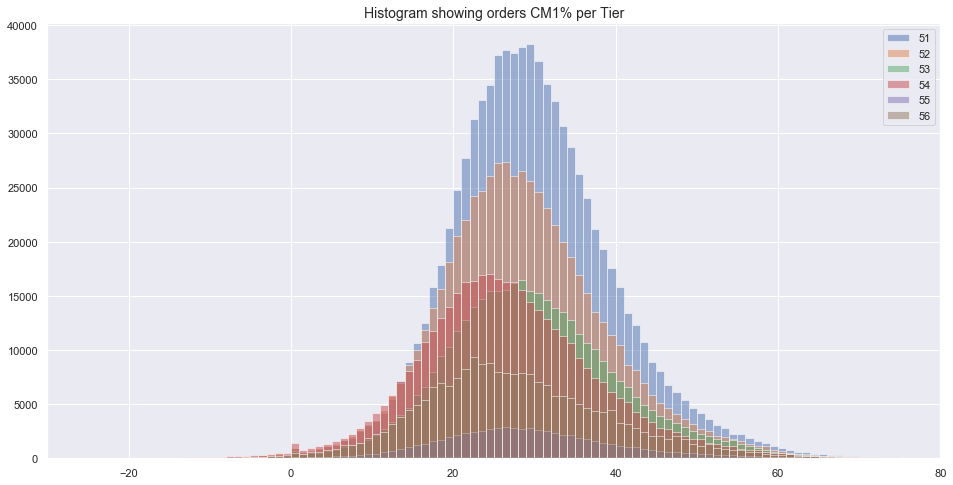

,Tier 51 Order_CM1%,Tier 52 Order_CM1%,Tier 53 Order_CM1%,Tier 54 Order_CM1%,Tier 55 Order_CM1%,Tier 56 Order_CM1%
count,862112.00,629611.00,398360.00,419115.00,70515.00,226754.00
25%,23.17,21.83,22.52,19.53,21.87,19.77
50%,29.08,27.91,28.93,25.97,28.44,26.59
75%,35.63,34.75,36.13,33.28,35.80,34.82


In [45]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM1% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm1 = [i for i in data_tier['SCM_D_FINANCE_CM1'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm1 = [i/j * 100 for i, j in list(zip(order_values_cm1, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm1, bins=100, range=(-25, 75), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm1).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM1%', 'Tier 52 Order_CM1%', 'Tier 53 Order_CM1%',
                     'Tier 54 Order_CM1%', 'Tier 55 Order_CM1%', 'Tier 56 Order_CM1%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

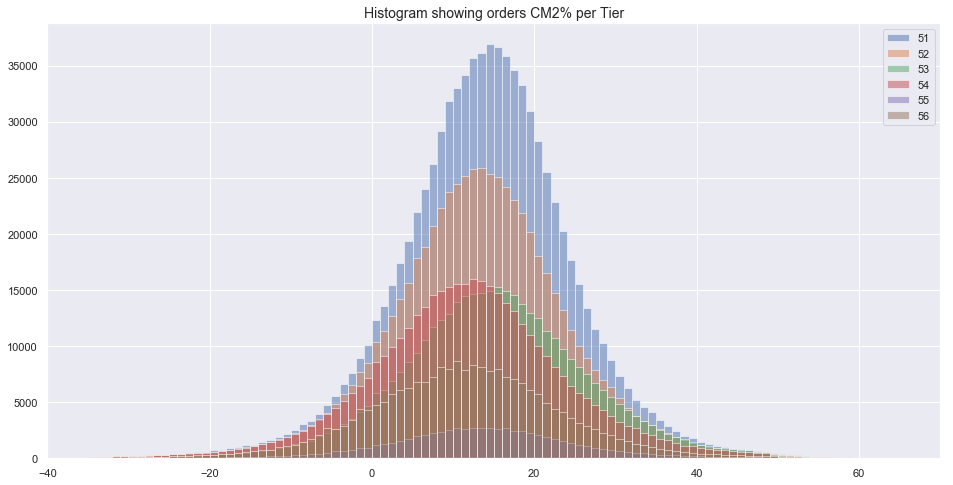

,Tier 51 Order_CM2%,Tier 52 Order_CM2%,Tier 53 Order_CM2%,Tier 54 Order_CM2%,Tier 55 Order_CM2%,Tier 56 Order_CM2%
count,862112.00,629611.00,398360.00,419115.00,70515.00,226754.00
25%,7.56,6.44,7.74,4.39,6.45,3.87
50%,14.10,13.18,14.91,11.71,13.47,11.50
75%,20.38,19.83,22.27,18.95,20.47,18.91


In [46]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM2% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm2 = [i for i in data_tier['SCM_D_FINANCE_CM2'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm2 = [i/j * 100 for i, j in list(zip(order_values_cm2, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm2, bins=100, range=(-35, 65), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm2).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM2%', 'Tier 52 Order_CM2%', 'Tier 53 Order_CM2%',
                     'Tier 54 Order_CM2%', 'Tier 55 Order_CM2%', 'Tier 56 Order_CM2%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

In [47]:
metrics_ztq = pd.DataFrame(columns=['ZTQ','active_customers', 'orders', 'sales_bmf', 'net_sales', 'CM1', 'CM2', 'CM1%', 'CM2%',
                                   'discount_amount', 'orders_%_neg_cm1', 'loss_in_CM1', 'orders_%_neg_cm2', 'loss_in_CM2'])
for tq in ztq:
    df_elems = []
    data_tier = data[data['CZP_ZTQ_ID'] == tq]
    df_elems.append(tq)
    df_elems.append(data_tier['CUS_N_KEY_CUSTOMER'].nunique())
    df_elems.append(data_tier['SCM_N_ORDER_NR'].nunique())
    df_elems.append(data_tier['SCM_SALES_BMF'].sum())
    df_elems.append(data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append((data_tier[data_tier['SCM_MASTER_AP_ID'] == 42715]['SCM_SALES_BMF']).sum())
    
    cm1_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()
    orders_neg_cm1 = cm1_per_order[cm1_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm1)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm1_per_order[cm1_per_order < 0].sum())
    
    cm2_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()
    orders_neg_cm2 = cm2_per_order[cm2_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm2)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm2_per_order[cm2_per_order < 0].sum())
    
    new_row = pd.DataFrame.from_records([df_elems], columns=metrics_ztq.columns)
    metrics_ztq = metrics_ztq.append(new_row, ignore_index=True)
    
display(metrics_ztq.round(2))

,ZTQ,active_customers,orders,sales_bmf,net_sales,CM1,CM2,CM1%,CM2%,discount_amount,orders_%_neg_cm1,loss_in_CM1,orders_%_neg_cm2,loss_in_CM2
0,51,132104,862226,47982410.14,43885753.23,12583525.75,6736065.78,28.67,15.35,-2500059.61,0.65,-30734.38,9.11,-190174.80
1,52,82953,629740,41148506.85,37474413.24,10275420.94,5400701.82,27.42,14.41,-2134138.75,0.93,-37954.08,10.86,-216268.50
2,53,57422,398433,25951838.79,23700110.38,6796249.96,3879730.69,28.68,16.37,-1936047.31,0.77,-17644.48,9.24,-110466.75
3,54,47768,419209,32242784.70,29290384.79,7438286.45,3763883.54,25.39,12.85,-2520203.37,1.45,-45418.47,14.97,-278554.20
4,55,17612,70533,4038479.29,3646762.67,1010598.35,521579.23,27.71,14.30,-207190.60,0.72,-2919.53,10.96,-25099.02
5,56,44422,226810,15298919.38,13772699.03,3450195.74,1675693.82,25.05,12.17,-1089140.83,1.02,-21874.18,16.03,-151686.44
